In [1]:
import Pkg; Pkg.activate(@__DIR__); Pkg.instantiate()

  Activating environment at `~/SSD/Code/TinyMPC/julia/quadrotor_quat/Project.toml`


In [2]:
using LinearAlgebra
using BlockDiagonals
using ForwardDiff
using Plots
using Random; 
using JuMP
using COSMO
using Printf
using ControlSystems

In [248]:
#Quaternion stuff
function hat(v)
    return [0 -v[3] v[2];
            v[3] 0 -v[1];
            -v[2] v[1] 0]
end
function L(q)
    s = q[1]
    v = q[2:4]
    L = [s    -v';
         v  s*I+hat(v)]
    return L
end
T = Diagonal([1; -ones(3)])
H = [zeros(1,3); I]
function qtoQ(q)
    return H'*T*L(q)*T*L(q)*H
end
function G(q)
    G = L(q)*H
end
function rptoq(ϕ)
    (1/sqrt(1+ϕ'*ϕ))*[1; ϕ]
end
function qtorp(q)
    q[2:4]/q[1]
end

qtorp (generic function with 1 method)

In [474]:
#Quadrotor parameters
m = 0.027
J = [16.6e-6 0.83e-6 0.72e-6;
    0.83e-6 16.6e-6 1.8e-6;
    0.72e-6 1.8e-6 29.3e-6];
g = 9.81

h = 1/500 #500 Hz

Nx = 13     # number of states (quaternion)
Nx̃ = 12
Nu = 4     # number of controls
Tfinal = 3.0 # final time
Nt = Int(Tfinal/h)+1    # number of time steps
t_vec = h*(0:Nt-1)
thist = Array(range(0,h*(Nt-1), step=h));

In [475]:
function quad_dynamics(x,u)
    r = x[1:3]
    q = x[4:7]/norm(x[4:7]) #normalize q just to be careful
    v = x[8:10]
    ω = x[11:13]
    Q = qtoQ(q)
    
    ṙ = Q*v
    q̇ = 0.5*L(q)*H*ω
    
    v̇ = Q'*[0; 0; -g] + (1/m)*[0; 0; u[1]] - hat(ω)*v
    
    ω̇ = J\(-hat(ω)*J*ω + u[2:4])
    
    return [ṙ; q̇; v̇; ω̇]
end

quad_dynamics (generic function with 1 method)

In [476]:
function quad_dynamics_rk4(x,u)
    #RK4 integration with zero-order hold on u
    f1 = quad_dynamics(x, u)
    f2 = quad_dynamics(x + 0.5*h*f1, u)
    f3 = quad_dynamics(x + 0.5*h*f2, u)
    f4 = quad_dynamics(x + h*f3, u)
    xn = x + (h/6.0)*(f1 + 2*f2 + 2*f3 + f4)
    xn[4:7] .= xn[4:7]/norm(xn[4:7]) #re-normalize quaternion
    return xn
end

quad_dynamics_rk4 (generic function with 1 method)

In [477]:
#Initial Conditions
# uhover = (m*g/4)*ones(4)
uhover = [m*g; 0; 0; 0]
r0 = [0.0; 0; 1.0]
q0 = [1.0; 0; 0; 0]
v0 = zeros(3)
ω0 = zeros(3)
x0 = [r0; q0; v0; ω0];

In [478]:
#Linearize dynamics about hover
A = ForwardDiff.jacobian(x->quad_dynamics_rk4(x,uhover),x0)
B = ForwardDiff.jacobian(u->quad_dynamics_rk4(x0,u),uhover);
#Reduced system
Ã = Array(E(q0)'*A*E(q0))
B̃ = Array(E(q0)'*B);

In [488]:
# Cost weights
Q = Array(diagm([10, 10, 10,  1, 1, 1,  1, 1, 1,  1, 1, 1]));
# Q = Array(I(Nx̃))
R = Array(10*I(Nu));
#LQR Controller
K = dlqr(Ã,B̃,Q,R)

4×12 Matrix{Float64}:
 1.44687e-11   2.08886e-10   0.985571     …  5.87803e-14  -3.9114e-14
 0.00130049   -0.0260519    -7.85179e-13     0.000416843   0.00035862
 0.0260513    -0.00130049    5.70935e-13     0.00834999    0.000896789
 0.00281519   -0.00112577    4.53435e-14     0.00090237    0.0146257

In [ ]:
static float K[NU][NXt] = {
  {0.000000f,0.000000f,0.689184f,0.000000f,0.000000f,0.000000f,0.000000f,0.000000f,0.715675f,0.000000f,0.000000f,0.000000f},
  {0.000039f,-0.000787f,0.000000f,0.008869f,0.000443f,0.000036f,0.000058f,-0.001153f,0.000000f,0.000874f,0.000044f,0.000036f},
  {0.000787f,-0.000039f,0.000000f,0.000443f,0.008869f,0.000089f,0.001153f,-0.000058f,0.000000f,0.000044f,0.000874f,0.000090f},
  {0.000085f,-0.000034f,0.000000f,0.000383f,0.000958f,0.001455f,0.000125f,-0.000050f,0.000000f,0.000038f,0.000094f,0.001469f},
};

now
static float K[NU][NXt] = {
  {0.000000f,0.000000f,0.689184f,0.000000f,0.000000f,0.000000f,0.000000f,0.000000f,0.715675f,0.000000f,0.000000f,0.000000f},
  {0.000039f,-0.000787f,0.000000f,0.008870f,0.000443f,0.000036f,0.000058f,-0.001153f,0.000000f,0.000874f,0.000044f,0.000036f},
  {0.000787f,-0.000039f,0.000000f,0.000443f,0.008870f,0.000090f,0.001153f,-0.000058f,0.000000f,0.000044f,0.000874f,0.000090f},
  {0.000085f,-0.000034f,0.000000f,0.000385f,0.000962f,0.001458f,0.000125f,-0.000050f,0.000000f,0.000038f,0.000095f,0.001472f},
};


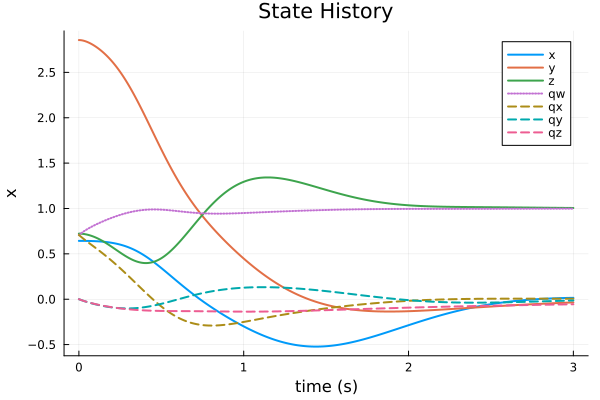

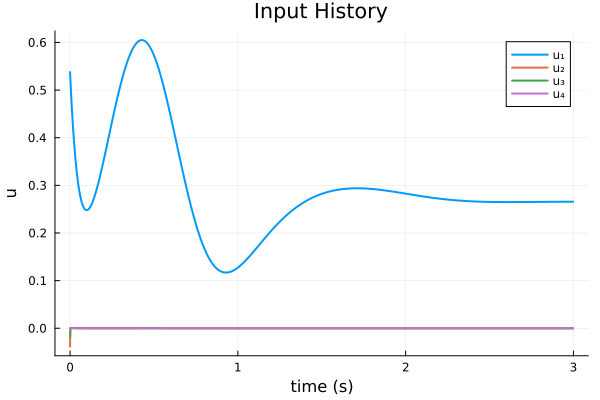

In [492]:
#Feedback controller
function controller(x)
    
    q0 = x0[4:7]
    q = x[4:7]
    ϕ = qtorp(L(q0)'*q)
    
    Δx̃ = [x[1:3]-r0; ϕ; x[8:10]-v0; x[11:13]-ω0]
    
    u = uhover - K*Δx̃
end
#Simulation
uhist = zeros(Nu,Nt-1)
xhist = zeros(Nx,Nt)
xhist[:,1] = [r0+randn(3); L(q0)*rptoq([1; 0; 0]); v0; ω0]
for k = 1:(Nt-1)
    uhist[:,k] = controller(xhist[:,k])
    xhist[:,k+1] = quad_dynamics_rk4(xhist[:,k],uhist[:,k])
end
display(plot(t_vec,xhist[1:7,:]',label=["x" "y" "z" "qw" "qx" "qy" "qz" ],
linestyle=[:solid :solid :solid :dot :dash :dash :dash], linewidth=[2 2 2 2 2 2 2],
             title="State History", xlabel="time (s)", ylabel="x"))
display(plot(t_vec[1:end-1],uhist',label=["u₁" "u₂" "u₃" "u₄"],
             title="Input History", linewidth=[2 2 2 2 2 2 2],
             xlabel="time (s)", ylabel="u"))

In [140]:
#Set up visualization
using TrajOptPlots
using MeshCat
using StaticArrays
using RobotZoo:Quadrotor

vis = Visualizer()
render(vis)

┌ Info: MeshCat server started. You can open the visualizer by visiting the following URL in your browser:
│ http://127.0.0.1:8703
└ @ MeshCat /home/khai/.julia/packages/MeshCat/GlCMx/src/visualizer.jl:73


MeshCat.DisplayedVisualizer(MeshCat.CoreVisualizer(MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), Set{Any}(), ip"127.0.0.1", 8703))

In [141]:
model = Quadrotor()
TrajOptPlots.set_mesh!(vis, model)

false

In [150]:
X1 = [SVector{13}(x) for x in eachcol(xhist)];
visualize!(vis, model, thist[end], X1)

In [493]:
display(K)
str = "static float K[NU][NXt] = {\n"
for i = 1:4
  str = str * "  {"
  for j = 1:12
    if abs(K[i, j]) < 1e-8
      K[i, j] = 0.0
    end
    this_str = @sprintf("%.6f", K[i, j])

    str = str * this_str * "f"
    if j < 12
      str = str * ","
    end
  end
  str = str * "},\n"
end
str = str * "};"
@printf("%s",str)


4×12 Matrix{Float64}:
 1.44687e-11   2.08886e-10   0.985571     …  5.87803e-14  -3.9114e-14
 0.00130049   -0.0260519    -7.85179e-13     0.000416843   0.00035862
 0.0260513    -0.00130049    5.70935e-13     0.00834999    0.000896789
 0.00281519   -0.00112577    4.53435e-14     0.00090237    0.0146257

static float K[NU][NXt] = {
  {0.000000f,0.000000f,0.985571f,0.000000f,0.000000f,0.000000f,0.000000f,0.000000f,0.387757f,0.000000f,0.000000f,0.000000f},
  {0.001300f,-0.026052f,0.000000f,0.112084f,0.005595f,0.000358f,0.000954f,-0.019119f,0.000000f,0.008350f,0.000417f,0.000359f},
  {0.026051f,-0.001300f,0.000000f,0.005595f,0.112082f,0.000896f,0.019118f,-0.000954f,0.000000f,0.000417f,0.008350f,0.000897f},
  {0.002815f,-0.001126f,0.000000f,0.004844f,0.012112f,0.014611f,0.002066f,-0.000826f,0.000000f,0.000361f,0.000902f,0.014626f},
};